In [1]:
from assets.one_mask.utils import parse_history_text, parse_history_text_CE
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import os

In [2]:
os.listdir('history/one_mask/')

['New',
 '.ipynb_checkpoints',
 'test.txt',
 'withoutCLAHE_withRecons_alpha01_lr0001.txt',
 'withoutCLAHE_withRecons_alpha01_lr00001_3channel.txt',
 '901.txt',
 '900.txt',
 'withoutCLAHE_withRecons_alpha01_lr0001_3channel.txt',
 'pretraning_lr00001_3channel.txt',
 '9_useCLAHE_05CE.txt',
 'Old',
 'withoutCLAHE_withRecons_alpha01_lr00001.txt']

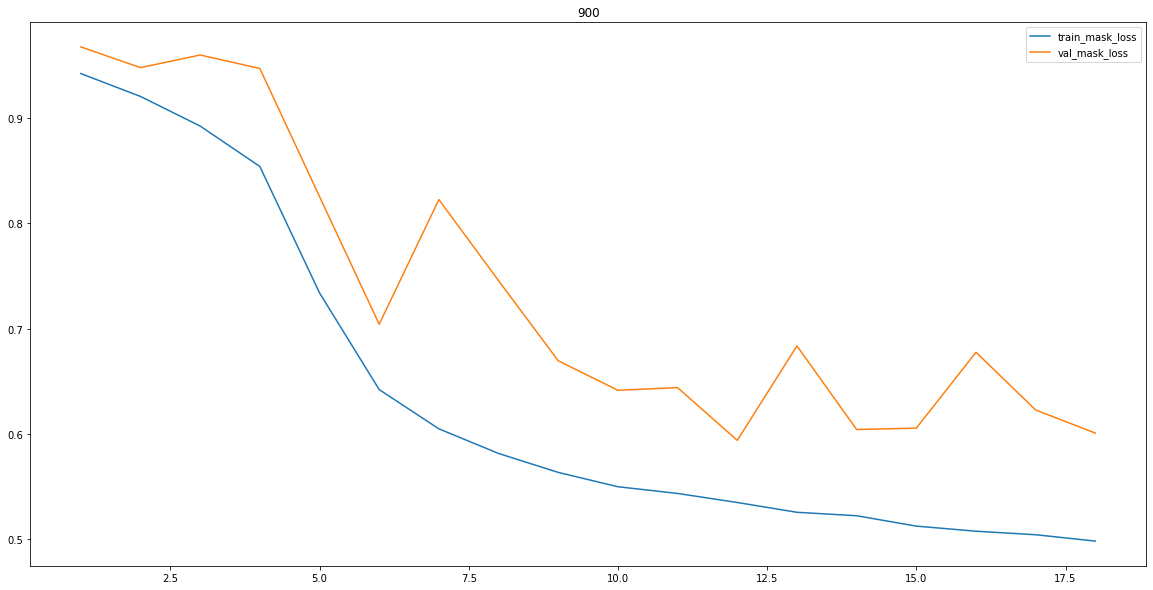

In [4]:
file_name = '900'
history = parse_history_text(f'history/one_mask/{file_name}.txt')

plt.figure(figsize=(20, 10))

plt.plot(history['epoch'], history['train_mask_loss'], label='train_mask_loss')
plt.plot(history['epoch'], history['val_mask_loss'], label='val_mask_loss')

plt.title(f'{file_name}')
plt.legend()
plt.show()

In [5]:
from keras import backend as K
from keras.engine.topology import Layer
from scipy.stats import bernoulli
import copy

from tensorflow.keras.layers import Layer, InputSpec


ModuleNotFoundError: No module named 'keras.engine.topology'

# 새롭게 뽑은 애들로 평가해보기

In [49]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

from assets.one_mask.data_generator_new import DR_Generator
from assets.one_mask.models import SMD_Unet 
from assets.one_mask.trainer import Trainer
from assets.one_mask.loss import dice_loss

ma_df = pd.read_csv('../data/mask_analysis.csv')
ma_df = ma_df.fillna('x')

file_names = list(ma_df['file_name'].values)

tr_file_names = file_names[:1108]
val_file_names = file_names[1108:1660]
ts_file_names = file_names[1660:1840]

origin_tr_len = len(tr_file_names)
origin_val_len = len(val_file_names)
origin_ts_len = len(ts_file_names)

# 심각하게 넓게 잡힌 애들
useless_1 = ma_df[ma_df['넒게 잡힘'] == 'ㅇ(심각)']['file_name'].values

# 실제론 있는데 마스크가 안잡혀있는 애들
cond1 = ma_df['안잡힘'] == 'ㅇ';cond2 = ma_df['덜잡힘'] == 'ㅇ'
useless_2 = ma_df[cond1 & cond2]['file_name'].values

# 이상하게 잡힌 애들
cond1 = ma_df['넒게 잡힘'] == 'ㅇ(이상)'; cond2 = ma_df['넒게 잡힘'] == 'ㅇ(이상하게 잡힘)'
useless_3 = ma_df[cond1 | cond2]['file_name'].values

# 레이저 치료 흔적 같은 애들
cond1 = ma_df['이상함(망막박리, 레이저 등)'] == 'ㅇ'
useless_4 = ma_df[cond1]['file_name'].values

useless_files = []
useless_files.extend(useless_1)
useless_files.extend(useless_2)
useless_files.extend(useless_3)
useless_files.extend(useless_4)

tr_file_names = [file for file in tr_file_names if file not in useless_files]
val_file_names = [file for file in val_file_names if file not in useless_files]
ts_file_names = [file for file in ts_file_names if file not in useless_files]

# 쓸모없는 애들 뺴고 난 길이
print("쓸모없는 애들 뺴고 난 길이")
print("-----------------------")
print("train:", len(tr_file_names))
print("valid:",len(val_file_names))
print("test:",len(ts_file_names))

# 얼마나 빠졌는지 확인해보자
print("빠진 개수")
print("-----------------------")
print("train:", origin_tr_len - len(tr_file_names))
print("valid:", origin_val_len - len(val_file_names))
print("test:", origin_ts_len - len(ts_file_names))

# 확실히 validation이 많이 빠졌네. 값이 왜 튀었는지 이유를 알 수 있다.

쓸모없는 애들 뺴고 난 길이
-----------------------
train: 997
valid: 455
test: 152
빠진 개수
-----------------------
train: 111
valid: 97
test: 28


In [3]:
masks = ['HardExudate_Masks', 'Hemohedge_Masks', 'Microaneurysms_Masks', 'SoftExudate_Masks']
mask_dir = '../data/FGADR/Seg-set'
mask_paths = [os.path.join(mask_dir, mask) for mask in masks]

generator_args = {
    'dir_path':'../data/FGADR/Seg-set/Original_Images/',
    'mask_path':mask_paths,
    'use_mask':True,
    'img_size':(512, 512),  
    'batch_size':4, # 8로 하면 바로 OOM 뜸
    'dataset':'FGADR', # FGADR or EyePacks
    'use_3channel':True,
    'CLAHE_args':None
}

tr_fgadr_gen = DR_Generator(is_train=True, file_names=tr_file_names,  **generator_args)
val_fgadr_gen = DR_Generator(is_train=False, file_names=val_file_names, **generator_args)
ts_fgadr_gen = DR_Generator(is_train=False, file_names=ts_file_names, **generator_args)

In [20]:
# model = SMD_Unet(enc_filters=[64, 128, 256, 512, 1024], dec_filters=[512, 256, 64, 32], input_channel=3)

# model_name = "3_3channel_CE_1_CLAHE_alpha01_lr0001/24"
# model.load_weights(f'../models/one_mask/New/{model_name}')

## Precision Recall 계산하기

In [35]:
# 확인하려는 모델들 path 넣어주기
check_models = [
    '3_3channel_CE_1_CLAHE_alpha01_lr0001/24',
    '3_3channel_CE_1_alpha01_lr0001/50',
    '3_3channel_CE_alpha01_lr0001/49',
    '3_1_3channel_alpha01_lr00001/8',
    '9_CLAHE_CE/36']

# threshold 정해주기
threshold = 0.001

for model_name in check_models:
    model = SMD_Unet(enc_filters=[64, 128, 256, 512, 1024], dec_filters=[512, 256, 64, 32], input_channel=3)
    try:
        model.load_weights(f'../models/one_mask/New/{model_name}')
        print("model_name:", model_name)
        print("-"*20, "start", "-"*20)
    except:
        continue
    
    # Train 
    
    tr_recall_list = []
    tr_precision_list = []
    
    # 정답이 없는 걸 없다고 잘 맞췄는가
    # 정답이 0인 개수
    tr_n_zero = 0
    # 정답이 0일 때 0이라고 답한 개수
    tr_true_zero = 0
    # 정답이 0일 때 0이라고 대답하지 못한 개수
    tr_false_zero = 0
    # 정답이 0이 아닌데 0이라고 답한 개수
    tr_false_negative_zero = 0
    
    for x_batch, y_batch in tqdm(tr_fgadr_gen):
        preds = model(x_batch[0], only_recons=False, training=False)

        y_true = y_batch.numpy()
        
        y_pred = preds[1].numpy()
        y_pred[y_pred > threshold] = 1
        y_pred[y_pred != 1] = 0

        tp = (y_true * y_pred).sum()
        gt = y_true.sum()
        pred = y_pred.sum()
        
        # 정답이 없거나 예측치가 없는 경우 recall, precision 계산에서는 제외
        
        if gt == 0:
            tr_n_zero += 1
            
            if pred == 0:
                tr_true_zero +=1
            else:
                tr_false_zero +=1
            continue
        else:
            if pred == 0:
                tr_false_negative_zero += 1
                continue
            
        recall = tp / gt
        precision = tp / pred
        
        tr_recall_list.append(recall)
        tr_precision_list.append(precision)
    
    
    # Valid
        
    val_recall_list = []
    val_precision_list = []
    
    # 정답이 없는 걸 없다고 잘 맞췄는가
    # 정답이 0인 개수
    val_n_zero = 0
    # 정답이 0일 때 0이라고 답한 개수
    val_true_zero = 0
    # 정답이 0일 때 0이라고 대답하지 못한 개수
    val_false_zero = 0
    # 정답이 0이 아닌데 0이라고 답한 개수
    val_false_negative_zero = 0
    
    for x_batch, y_batch in tqdm(val_fgadr_gen):
        preds = model(x_batch[0], only_recons=False, training=False)

        y_true = y_batch.numpy()
        y_pred = preds[1].numpy()
        y_pred[y_pred > threshold] = 1
        y_pred[y_pred != 1] = 0

        tp = (y_true * y_pred).sum()
        gt = y_true.sum()
        pred = y_pred.sum()

        # 정답이 없거나 예측치가 없는 경우 recall, precision 계산에서는 제외
        
        if gt == 0:
            val_n_zero += 1
            
            if pred == 0:
                val_true_zero +=1
            else:
                val_false_zero +=1
            continue
        else:
            if pred == 0:
                val_false_negative_zero += 1
                continue
        
        recall = tp / gt
        precision = tp / pred
        
        val_recall_list.append(recall)
        val_precision_list.append(precision)
    
    # 정답이 0일 때 예측의 비율
    if tr_n_zero == 0:
        tr_true_zero_ratio = 0
        tr_false_zero_ratio = 0
    else:
        tr_true_zero_ratio = tr_true_zero / tr_n_zero
        tr_false_zero_ratio = tr_false_zero / tr_n_zero
    # 정답이 0이 아닐 때 0이라고 예측한 개수
    tr_false_negative_zero_ratio = tr_false_negative_zero / len(tr_fgadr_gen)
    
    # 정답이 0일 때 예측의 비율
    if val_n_zero == 0:
        val_true_zero_ratio = 0
        val_false_zero_ratio = 0
    else:
        val_true_zero_ratio = val_true_zero / val_n_zero
        val_false_zero_ratio = val_false_zero / val_n_zero
    # 정답이 0이 아닐 때 0이라고 예측한 개수
    val_false_negative_zero_ratio = val_false_negative_zero / len(val_fgadr_gen)
    
    print(f'train / recall : {np.mean(tr_recall_list):.4f} / precision : {np.mean(tr_precision_list):.4f} / '\
          f'true_zero_ratio : {tr_true_zero_ratio:.4f} / false_zero_ratio : {tr_false_zero_ratio:.4f} / '\
          f'false_negative_ratio : {tr_false_negative_zero_ratio:.4f}')
    print(f'valid / recall : {np.mean(val_recall_list):.4f} / precision : {np.mean(val_precision_list):.4f} / '\
          f'true_zero_ratio : {val_true_zero_ratio:.4f} / false_zero_ratio : {val_false_zero_ratio:.4f} / '\
          f'false_negative_ratio : {val_false_negative_zero_ratio:.4f}')
    
    print("-"*20, "end", "-"*20)
    print("")


model_name: 3_3channel_CE_1_CLAHE_alpha01_lr0001/24
-------------------- start --------------------


100%|██████████| 119/119 [01:48<00:00,  1.10it/s]


train / recall : 0.4793 / precision : 0.1455 / true_zero_ratio : 0.0000 / false_zero_ratio : 0.0000 / false_negative_ratio : 0.0000
valid / recall : 0.4789 / precision : 0.1371 / true_zero_ratio : 0.0000 / false_zero_ratio : 0.0000 / false_negative_ratio : 0.0000
-------------------- end --------------------

model_name: 3_3channel_CE_1_alpha01_lr0001/50
-------------------- start --------------------


100%|██████████| 119/119 [01:48<00:00,  1.10it/s]


train / recall : 0.8388 / precision : 0.1382 / true_zero_ratio : 0.0000 / false_zero_ratio : 0.0000 / false_negative_ratio : 0.0000
valid / recall : 0.8128 / precision : 0.1215 / true_zero_ratio : 0.0000 / false_zero_ratio : 0.0000 / false_negative_ratio : 0.0000
-------------------- end --------------------

model_name: 3_3channel_CE_alpha01_lr0001/49
-------------------- start --------------------


100%|██████████| 119/119 [01:49<00:00,  1.09it/s]


train / recall : 0.7572 / precision : 0.2730 / true_zero_ratio : 0.0000 / false_zero_ratio : 0.0000 / false_negative_ratio : 0.0000
valid / recall : 0.6862 / precision : 0.2326 / true_zero_ratio : 0.0000 / false_zero_ratio : 0.0000 / false_negative_ratio : 0.0000
-------------------- end --------------------

model_name: 3_1_3channel_alpha01_lr00001/8
-------------------- start --------------------


100%|██████████| 119/119 [01:48<00:00,  1.10it/s]


train / recall : 0.5875 / precision : 0.5684 / true_zero_ratio : 0.0000 / false_zero_ratio : 0.0000 / false_negative_ratio : 0.0000
valid / recall : 0.5251 / precision : 0.4901 / true_zero_ratio : 0.0000 / false_zero_ratio : 0.0000 / false_negative_ratio : 0.0000
-------------------- end --------------------

model_name: 9_CLAHE_CE/36
-------------------- start --------------------


100%|██████████| 119/119 [01:48<00:00,  1.10it/s]

train / recall : 0.2649 / precision : 0.5328 / true_zero_ratio : 0.0000 / false_zero_ratio : 0.0000 / false_negative_ratio : 0.0000
valid / recall : 0.2636 / precision : 0.4869 / true_zero_ratio : 0.0000 / false_zero_ratio : 0.0000 / false_negative_ratio : 0.0000
-------------------- end --------------------



# mask loss만 따로 계산하기

In [25]:
train_mask_losses = []

for x_batch, y_batch in tqdm(tr_fgadr_gen):
    preds = model(x_batch[0], only_recons=False, training=False)
    
    mask_loss = dice_loss(y_batch, preds[1])
    
    train_mask_losses.append(mask_loss.numpy())
    
print(f"mask_train_loss: {np.mean(train_mask_losses)}")

val_mask_losses = []


for x_batch, y_batch in tqdm(val_fgadr_gen):
    
    preds = model(x_batch[0], only_recons=False, training=False)
    
    mask_loss = dice_loss(y_batch, preds[1])
    
    val_mask_losses.append(mask_loss.numpy())
    
print(f"mask_val_loss: {np.mean(val_mask_losses)}")

  1%|          | 2/261 [00:03<07:15,  1.68s/it]


KeyboardInterrupt: 

In [ ]:
1	1_alpha01_lr0001/28
1-1	1_1_alpha01_lr00001/38
2	2_alpha00_lr0001/28
2-1	2_1_alpha00_lr00001/16
3	3_3channel_alpha01_lr0001/38
3-1	3_1_3channel_alpha01_lr00001/8
3-2	3_3channel_CE_alpha01_lr0001/49
3-3	3_3channel_CE_1_alpha01_lr0001/50
4	4_pretraining_3channel_alpha01_lr0001/49
4-1	4_1_pretraining_3channel_alpha01_lr00001/6
5	5_pretraining_3channel_addnoise_alpha01_lr0001/28
5-1	5_1_pretraining_3channel_addnoise_alpha01_lr00001/9
6	6_pretraining_1channel_alpha01_lr0001/20, 31
6-1	6_1_pretraining_1channel_alpha01_lr00001_epoch20
6-2	6_2_pretraining_1channel_alpha01_lr00001_epoch31
pretraining-1	pretraining_use3channel_lr00001/1
pretraining-2	pretraning_lr00001_3channel_addnoise/1
pretraining-3	pretraining_lr0001/1
7	
8	3_3channel_CE_1_CLAHE_alpha01_lr0001/24

# 모델 결과 시각화

In [5]:
from assets.one_mask.utils import parse_history_text
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

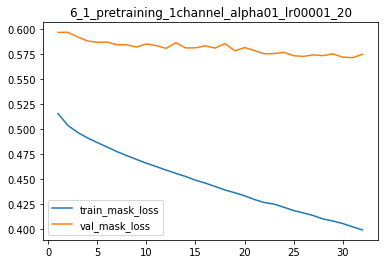

In [7]:
history = parse_history_text('history/one_mask/New/6_1_pretraining_1channel_alpha01_lr00001_20.txt')

plt.plot(history['epoch'], history['train_mask_loss'], label='train_mask_loss')
plt.plot(history['epoch'], history['val_mask_loss'], label='val_mask_loss')

plt.title('6_1_pretraining_1channel_alpha01_lr00001_20')
plt.legend()
plt.show()

In [ ]:
history = parse_history_text('history/one_mask/5_1_pretraining_3channel_addnoise_alpha01_lr00001.txt')

plt.plot(history['epoch'], history['train_mask_loss'], label='lr0.001')
plt.plot(history['epoch'], history['val_mask_loss'], label='lr0.001')


history = parse_history_text('history/one_mask/withoutCLAHE_withoutRecons_alpha00_lr00001.txt')

plt.plot(history['epoch'], history['train_mask_loss'], label='lr0.0001', linestyle='--')
plt.plot(history['epoch'], history['val_mask_loss'], label='lr0.0001', linestyle='--')

plt.title('lr')
plt.legend()
plt.show()

# 평가지표

In [2]:
import os
from assets.evaluation.evaluate_result import evaluate_main

In [8]:
generator_type = 'validation'  # 원하는 generator 타입 선택: 'train', 'validation', 또는 'test'
input_channel = 3         # 3channel은 3, 1channel은 1
use_3channel = True     # 3channel은 True, 1channel은 False
model_path = "../models/one_mask/New/3_1_3channel_alpha01_lr00001/8"  # 모델 경로 지정
result_df = evaluate_main(generator_type, model_path, input_channel, use_3channel)

100%|██████████| 138/138 [02:51<00:00,  1.24s/it]

CSV 파일 저장 완료: assets/evaluation/evaluation_results_csv/3_1_3channel_alpha01_lr00001_validation_evaluation_result.csv


# Prediction 결과 시각화

In [14]:
import pandas as pd

result_df = pd.read_csv("../data/Seg-set/DR_Seg_Grading_Label.csv", header=None)

In [46]:
ma_df[cond1 | cond2]

,file_name,"이상함(망막박리, 레이저 등)",넒게 잡힘,잘잡힘,덜잡힘,안잡힘,이미지 어두움,이미지 노이즈,이미지 흐림,삭제했으면 좋겠는 이미지,Unnamed: 10
22,0022_3.png,ㅇ,x,ㅇ,x,x,x,x,ㅇ,x,x
52,0052_2.png,ㅇ,x,x,x,x,x,x,x,x,x
54,0054_3.png,ㅇ,x,ㅇ,x,x,x,x,x,x,x
72,0072_2.png,ㅇ,x,ㅇ,x,x,x,x,x,x,x
127,0127_2.png,ㅇ,x,ㅇ,x,x,x,x,ㅇ,x,x
143,0143_3.png,ㅇ,ㅇ,x,x,x,x,x,x,x,x
150,0150_3.png,ㅇ,x,ㅇ,x,x,x,x,x,x,x
151,0151_3.png,ㅇ,x,ㅇ,x,x,x,x,x,x,x
191,0191_3.png,ㅇ,x,x,x,ㅇ,x,x,x,x,x
192,0192_3.png,ㅇ,x,ㅇ,x,x,x,x,x,x,x


In [48]:
# from assets.evaluation.evaluation_visual import visualize_segmentation_results

# image_filenames = ma_df[cond1 | cond2]['file_name'].values  # 원하는 이미지 파일명으로 수정
# #image_filenames = result_df

# mask_dir = '../data/FGADR/Seg-set'
# image_dir = '../data/FGADR/Seg-set/Original_Images/'
# #image_dir = '../data/FGADR/'

# model_path = "../models/one_mask/New/3_3channel_CE_1_CLAHE_alpha01_lr0001/23"
# visualize_segmentation_results(image_filenames, model_path, mask_dir, image_dir)